The aim of this notebook is to perform a quick test for an update of the model or a new optimization procedure.
To test a model update, each cell of this notebook must run with correct results.
To test a new optimization procedure, a new dedicated cell must be created on the same model as the previous ones.

As this pipeline consist in only one instance solved by each procedure once, it statisticaly has no meaning. For a statisticaly meaningful test pipeline, please run the Test pipeline notebook (heavily time consuming). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import set_init_point, prepare_tensions, adjust_tensions
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces

Error: IPOPT shared library failed to import


Using TensorFlow backend.


### Control randomness

In [2]:
def get_sequence(seed, theta, shape):
    np.random.seed(seed)
    
    return np.random.normal(1.0, theta, shape)
seed = 1553

Generate the theoritical organoïd

In [3]:
organo = generate_ring(10, 110, 150)
Nf= organo.Nf
geom.update_all(organo)
#alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))


# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  alpha*organo.face_df.area, 
        'area_elasticity': 1.,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 0.1,
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.,
        'x_ecm': 0.,
        'y_ecm': 0.,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 0.1,
        'lumen_prefered_vol': organo.settings['lumen_volume'],
        'lumen_volume': organo.settings['lumen_volume']
        }
    }

organo.update_specs(specs, reset=True)
normalize_scale(organo, geom, refer='edges')
geom.update_all(organo)

symetric_tensions = 10*set_init_point(organo.settings['R_in'], organo.settings['R_out'], organo.Nf, alpha)
sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf, endpoint=False)))**2
organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
organo.edge_df.line_tension = prepare_tensions(organo, symetric_tensions)
organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul

organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]

organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01

new_tensions = organo.edge_df.line_tension

organo.edge_df.loc[:,'line_tension'] = new_tensions
                                                          
res = Solver.find_energy_min(organo, geom, model)                                                       

Reseting datasets values with new specs


Creating a printing function

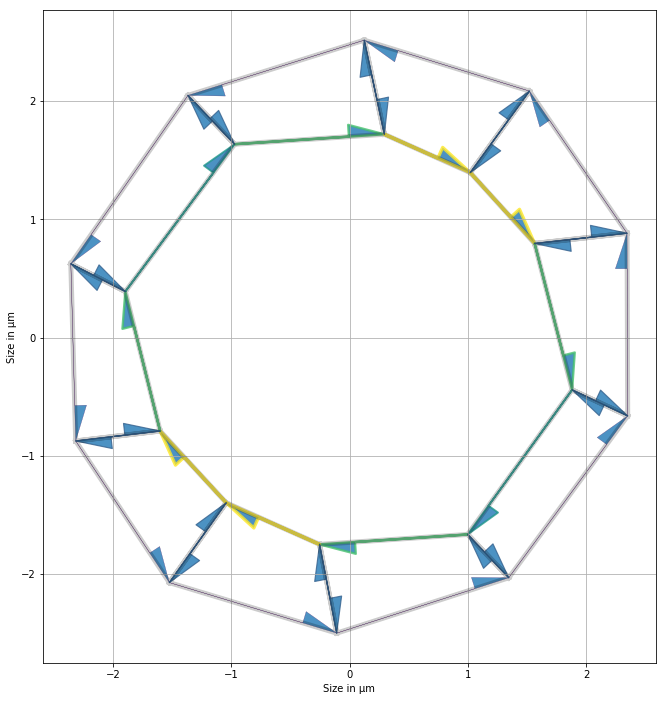

In [4]:
def print_tensions(exp_organo, th_organo):
    draw_specs = sheet_spec()
    tension_max = np.max(exp_organo.edge_df.line_tension.values.copy())
    edge_color = 1/tension_max*exp_organo.edge_df.line_tension.values.copy()
    cmap = plt.cm.get_cmap('viridis')
    edge_cmap = cmap(edge_color)
    draw_specs['vert']['visible'] = False
    draw_specs['edge']['color'] = edge_cmap
    draw_specs['edge']['width'] = 0.25+3*edge_color
    fig, ax = quick_edge_draw(th_organo, lw=5, c='k', alpha=0.2)
    fig, ax = sheet_view(exp_organo, ax=ax, **draw_specs)
    fig.set_size_inches(12, 12)
    plt.xlabel('Size in µm')
    plt.ylabel('Size in µm')
    
print_tensions(organo, organo)

Define the optimization parameters

In [5]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo.Nf),[1000]*(3*organo.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-3, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-8,'ftol': 1e-7, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', #'callback': printx,
            'output_path': './PSQP_areas.out'}

reg_weight = 1e-3
theta = 0.02

# Force inference with ONLY TENSIONS solved with NNLS

Energy before optimization:  17.43436531160144
Solving time: 8.805852000000002
Energy after optimization:  13.701850074227394
Distance: 11.887640390620215


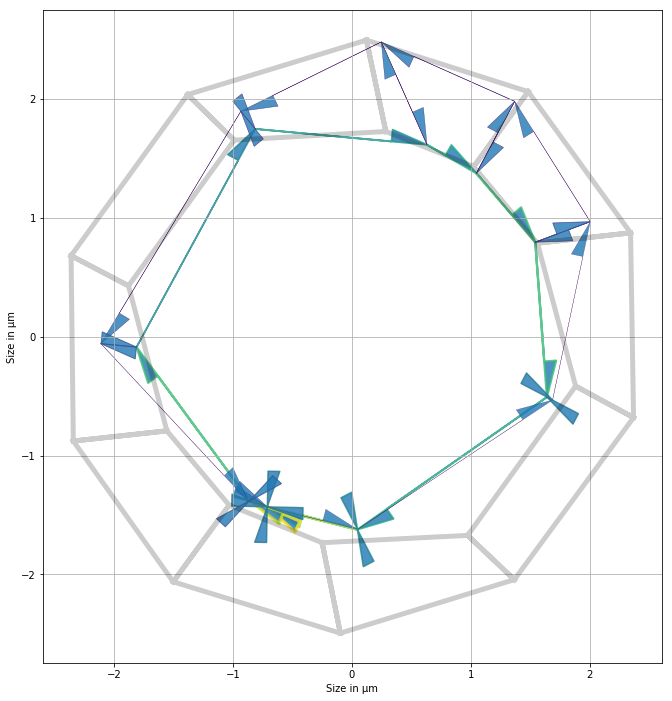

In [15]:
initial_guess = infer_forces(organo, 'NNLS', sup_param='')
start = time.clock()
tensions_organo = organo.copy()
tensions_organo.edge_df.line_tension = prepare_tensions(tensions_organo,
                                                        initial_guess['tensions'])
print('Energy before optimization: ', model.compute_energy(tensions_organo, False))
Solver.find_energy_min(tensions_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(tensions_organo, False))
print_tensions(tensions_organo, organo)
print('Distance: ' + str(np.sum(np.linalg.norm(_distance(organo, tensions_organo), axis=1))))

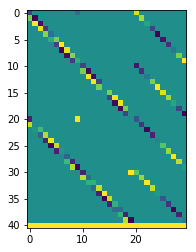

In [16]:
from tyssue_taylor.adjusters.force_inference import _coef_matrix
plt.imshow(_coef_matrix(organo, sup_param=''))

Comparaison vraies tensions / tensions obtenues

R value : 0.8906576793329333 
Standard error : 0.3766622764788102


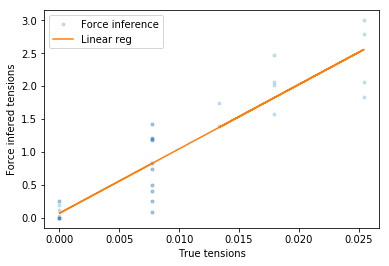

In [17]:
true_t = organo.edge_df.line_tension
opt_t = tensions_organo.edge_df.line_tension
slope, intercept, r_value, p_value, std_err = stats.linregress(true_t, opt_t)
plt.plot(true_t, opt_t, '.', alpha=0.2)
plt.plot(true_t, intercept+slope*true_t, '-')
plt.legend(('Force inference', 'Linear reg'), loc='upper left')
plt.xlabel('True tensions')
plt.ylabel('Force infered tensions')
std = np.sum(np.power(intercept+slope*true_t-opt_t, 2))
print('R value :', r_value, '\nStandard error :', (std/organo.Ne)**0.5)

In [57]:
timeit_org = organo.copy()
timeit_org.edge_df.line_tension = prepare_tensions(timeit_org,
                                                   initial_guess['tensions'])
%timeit Solver.find_energy_min(timeit_org, geom, model)

413 ms ± 51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Minimizing distance

`xtol` termination condition is satisfied.
Function evaluations 44, initial cost 2.3598e+00, final cost 2.3598e+00, first-order optimality 1.60e+05.
Solving time: 745.9648980000001


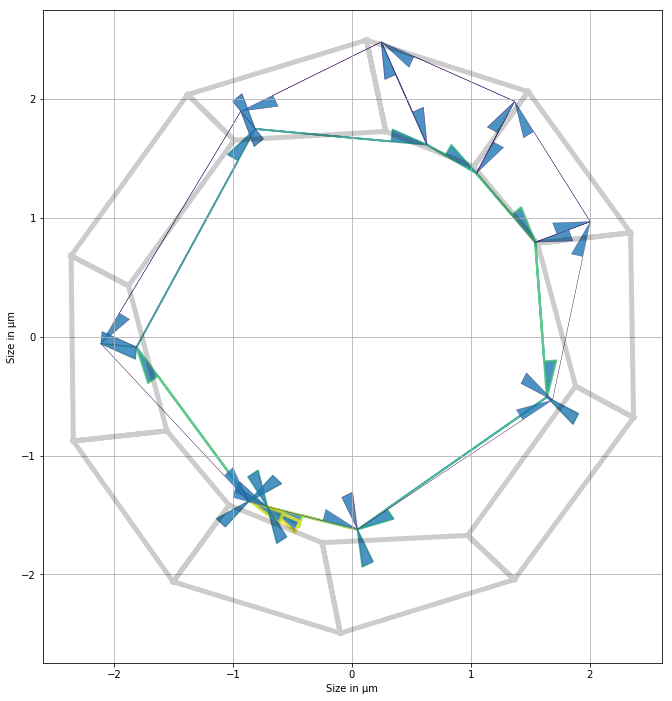

In [29]:
res_tensions = adjust_tensions(organo, initial_guess['tensions'], 
                               {'dic':{}, 'weight':0},
                               energy_opt, **lm_opt)
opt_tensions_organo = tensions_organo.copy()
opt_tensions_organo.edge_df.line_tension = prepare_tensions(opt_tensions_organo, res_tensions.x)
Solver.find_energy_min(opt_tensions_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(opt_tensions_organo, organo)

# Force inference with PRESSIONS solved with NNLS

Energy before optimization:  0.21705616863811097
Solving time: 0.8670780000000002
Energy after optimization:  0.21590496323177438
Distance: 2.0260105275222444


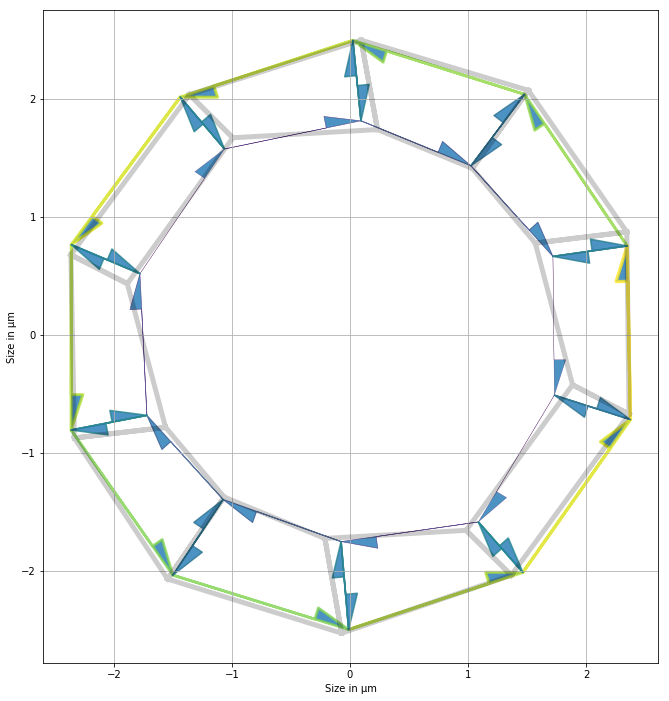

In [11]:
initial_guess = infer_forces(organo, 'NNLS', sup_param='pressions')
start = time.clock()
pressions_organo = organo.copy()
pressions_organo.edge_df.line_tension = prepare_tensions(pressions_organo,
                                                         initial_guess['tensions'])
print('Energy before optimization: ', model.compute_energy(pressions_organo, False))
Solver.find_energy_min(pressions_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(pressions_organo, False))
print_tensions(pressions_organo, organo)
print('Distance: ' + str(np.sum(np.linalg.norm(_distance(organo, pressions_organo), axis=1))))

Comparaison des vraies tensions et des tensions inférées

R value : -0.8208599036948909 
Standard error : 0.0032887113398197684


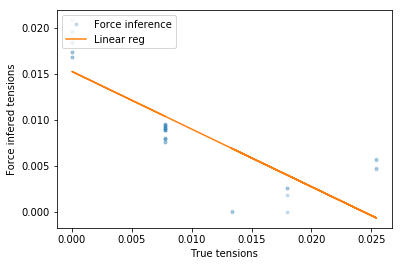

In [12]:
true_t = organo.edge_df.line_tension
opt_t = pressions_organo.edge_df.line_tension
slope, intercept, r_value, p_value, std_err = stats.linregress(true_t, opt_t)
plt.plot(true_t, opt_t, '.', alpha=0.2)
plt.plot(true_t, intercept+slope*true_t, '-')
plt.legend(('Force inference', 'Linear reg'), loc='upper left')
plt.xlabel('True tensions')
plt.ylabel('Force infered tensions')
std = np.sum(np.power(intercept+slope*true_t-opt_t, 2))
print('R value :', r_value, '\nStandard error :', (std/organo.Ne)**0.5)

## Minimizing distance

In [ ]:
res_pressions = adjust_tensions(pressions_organo, initial_guess['tensions'],
                                {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                energy_opt, **lm_opt)
opt_pressions_organo = pressions_organo.copy()
opt_pressions_organo.edge_df.line_tension = prepare_tensions(opt_pressions_organo, res_pressions.x)
Solver.find_energy_min(opt_pressions_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(opt_pressions_organok, organo)

# Force inference with AREAS solved with NNLS

[-1.22963415  1.66382592 -0.65318437  0.13389603  1.7478575   0.47909118
  0.89274563  1.39603386  1.21198085  0.66442314  0.78967513 -0.11995504
 -0.46143066 -0.38945741 -0.91793264  1.45623164 -1.63428658  0.91820917
  0.02044587 -1.7183037  -0.81216626 -1.34750129 -1.39437651 -1.46059527
 -0.94512585 -0.79544237 -0.01824622  0.81594963  0.44148876  1.37279858]
[ -0.81325002   0.60102441  -1.53096132   7.4684811    0.57212902
   2.08728534   1.12013989   0.71631501   0.82509554   1.50506498
   1.26634354  -8.33645701  -2.16717284  -2.56767484  -1.08940456
   0.68670394  -0.61188779   1.08907646  48.90962454  -0.5819693
  -1.23127498  -0.74211432  -0.71716641  -0.68465236  -1.05806015
  -1.2571621  -54.80586336   1.22556585   2.2650633    0.72843898]
Energy before optimization:  2.241437514332535
Solving time: 4.247726999999998
Energy after optimization:  1.6077868972382832


12.90834219249738

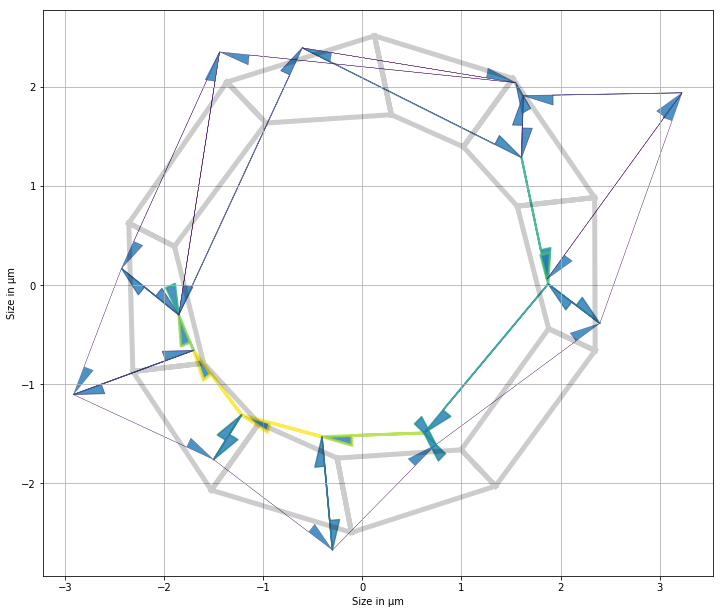

In [18]:
initial_guess = infer_forces(organo, 'NNLS', sup_param='areas')
start = time.clock()
areas_organo = organo.copy()
areas_organo.edge_df.line_tension = prepare_tensions(areas_organo, 0.1*initial_guess['tensions'])
areas_organo.face_df.prefered_area = areas_organo.face_df.area + initial_guess['areas'][:-1]
print('Energy before optimization: ', model.compute_energy(areas_organo, False))
Solver.find_energy_min(areas_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(areas_organo, False))
print_tensions(areas_organo, organo)
np.sum(np.linalg.norm(_distance(organo, areas_organo), axis=1))

Comparaison des vraies tensions et des tensions inférées

In [22]:
initial_guess['tensions'].mean()


0.9910928851337161

R value : 0.7584543995499944 
Standard error : 0.058632132560863845


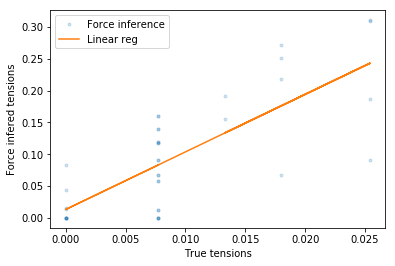

In [19]:
true_t = organo.edge_df.line_tension
opt_t = areas_organo.edge_df.line_tension
slope, intercept, r_value, p_value, std_err = stats.linregress(true_t, opt_t)
plt.plot(true_t, opt_t, '.', alpha=0.2)
plt.plot(true_t, intercept+slope*true_t, '-')
plt.legend(('Force inference', 'Linear reg'), loc='upper left')
plt.xlabel('True tensions')
plt.ylabel('Force infered tensions')
std = np.sum(np.power(intercept+slope*true_t-opt_t, 2))
print('R value :', r_value, '\nStandard error :', (std/organo.Ne)**0.5)

Comparaison des vraies aires de préference et des aires de préference trouvées

R value : 0.09703606828440652 
Standard error : 0.2214588898410834


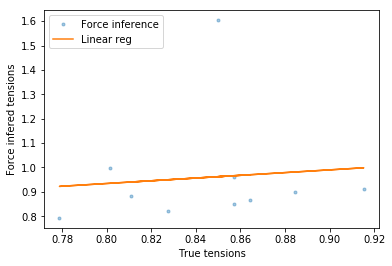

In [20]:
true_a = organo.face_df.prefered_area
opt_a = areas_organo.face_df.prefered_area
slope, intercept, r_value, p_value, std_err = stats.linregress(true_a, opt_a)
plt.plot(true_a, opt_a, '.', alpha=0.4)
plt.plot(true_a, intercept+slope*true_a, '-')
plt.legend(('Force inference', 'Linear reg'), loc='upper left')
plt.xlabel('True tensions')
plt.ylabel('Force infered tensions')
std = np.sum(np.power(intercept+slope*true_a-opt_a, 2))
print('R value :', r_value, '\nStandard error :', (std/organo.Nf)**0.5)

## Minimizing distance

[0.29039973 1.6199301  0.53740438 0.42397919 0.69782464 0.69438447
 1.66612839 1.04852937 0.75784005 0.63090881 0.56886816 2.079978
 1.2463855  1.14459628 1.25183641 1.03993949 0.90610556 1.78659436
 0.71277049 1.0032718  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.29039973 1.6199301  0.53740438 0.42397919 0.69782464 0.69438447
 1.66612839 1.04852937 0.75784005 0.63090881 0.56886816 2.079978
 1.2463855  1.14459628 1.25183641 1.03993949 0.90610556 1.78659436
 0.71277049 1.0032718  0.         0.         0.         0.
 0.         0.         0.

[0.31201497 1.62124089 0.53167469 0.41619155 0.69591975 0.69236958
 1.69290504 1.07788194 0.80971915 0.65995599 0.54927812 2.05941265
 1.23882313 1.12994914 1.25439372 1.00689128 0.93707568 1.82238171
 0.6670264  1.04435555 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.31636941 1.64048962 0.55653    0.40719129 0.73230709 0.71358594
 1.69982364 1.09027749 0.75888169 0.64741012 0.57734277 2.10053301
 1.26222511 1.13571393 1.28596906 1.06090943 0.94485323 1.84234696
 0.72728918 1.05449141 0.         0.         0.         0.
 0.         0.       

[0.34782046 1.76894517 0.69692797 0.31074589 0.90746745 0.83316002
 1.95827358 1.24373311 0.91161367 0.74413567 0.52164964 2.23402941
 1.38599552 1.09245869 1.51066606 1.20608282 1.17681545 2.06068325
 0.76806818 1.14707191 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.35424009 1.62131561 0.53467254 0.41537317 0.69708204 0.67509652
 1.70062384 1.05376153 0.75645585 0.66959418 0.56509027 2.07987528
 1.24270473 1.1330399  1.25935176 1.03996207 0.93405261 1.82247913
 0.72899419 1.04955352 0.         0.         0.         0.
 0.         0.       

[0.31668731 1.66843915 0.59201263 0.38016318 0.7722306  0.75325193
 1.75127166 1.16351893 0.80706427 0.68315379 0.56049526 2.12993022
 1.29506107 1.12312147 1.33701369 1.09628739 0.99390794 1.90520159
 0.75167232 1.08790244 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.34413177 1.77463088 0.7054548  0.33070921 0.90999891 0.86799749
 1.92860492 1.23573873 0.88612451 0.72226402 0.5416562  2.24140083
 1.39873019 1.11374682 1.51021048 1.22685426 1.10838462 2.00594639
 0.71487291 1.08801824 0.         0.         0.         0.
 0.         0.       

[0.31966204 1.6219452  0.53216806 0.41594108 0.69769264 0.67333734
 1.69778196 1.07265634 0.76543978 0.67741889 0.56989497 2.08094868
 1.23851087 1.12989192 1.25848853 1.0286587  0.93953557 1.82956056
 0.72700138 1.04738643 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.30409168 1.64614659 0.55438735 0.39599549 0.74361074 0.7041748
 1.72232893 1.1382426  0.81242002 0.67167054 0.54287801 2.10534032
 1.25499978 1.12148231 1.30093519 1.04042538 0.97486252 1.87029904
 0.67434978 1.0676097  0.         0.         0.         0.
 0.         0.        

[0.24648865 1.30003024 0.50425715 0.45056799 0.57095782 0.55341106
 1.41079637 0.88879941 0.61223969 0.57346566 0.5760848  1.72849781
 1.21970391 1.15533936 1.00646468 0.89168388 0.68571278 1.49294544
 0.68409659 0.89985336 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[3.24814182e-01 1.62726546e+00 5.42884769e-01 4.17932539e-01
 6.97793214e-01 6.92078732e-01 1.68475286e+00 1.06289085e+00
 7.47942053e-01 6.69375566e-01 6.12313430e-01 2.08580711e+00
 1.24748829e+00 1.14186797e+00 1.26311945e+00 1.04947788e+00
 9.20229783e-01 1.82212839e+00 7.5881

[0.32538775 1.6357376  0.54167652 0.39817984 0.72353338 0.68701587
 1.72242459 1.10828806 0.78143335 0.68268978 0.53693228 2.09367245
 1.2426301  1.1185646  1.28015071 1.03224952 0.98193661 1.85825627
 0.72586996 1.07038666 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.33359362 1.63027378 0.53811594 0.40973089 0.71017462 0.68271009
 1.70405845 1.09432099 0.76687606 0.67696701 0.54083089 2.08816019
 1.24025284 1.12804736 1.26716166 1.03060265 0.95709611 1.83572518
 0.70994018 1.05485818 0.         0.         0.         0.
 0.         0.       

[0.29814326 1.6347275  0.55161155 0.41178767 0.72077115 0.69585206
 1.75220046 1.14051273 0.76655433 0.69404699 0.55887416 2.09516346
 1.25800131 1.13838597 1.30573339 1.02534232 0.93085996 1.83491246
 0.733864   1.04545228 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.33972846 1.76448213 0.70397926 0.32080904 0.90606288 0.85565863
 1.95796125 1.23084704 0.90635618 0.71243656 0.54182948 2.23197342
 1.39619609 1.10386937 1.51586979 1.22282311 1.08548303 1.98022097
 0.74394152 1.08383137 0.         0.         0.         0.
 0.         0.       

[0.32703976 1.62404545 0.53798726 0.41989113 0.70388039 0.68157846
 1.69306796 1.0722219  0.72677668 0.67252885 0.5694311  2.07910475
 1.24077158 1.13935716 1.26025205 1.02686515 0.93082317 1.81875439
 0.73322649 1.04171331 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.36374031 1.73917531 0.66116374 0.34135547 0.87888927 0.81887032
 1.85420314 1.24243339 0.83825706 0.69551218 0.50274259 2.20308592
 1.35425936 1.11070746 1.44301872 1.16746984 1.10312693 2.00470033
 0.75064191 1.12929671 0.         0.         0.         0.
 0.         0.       

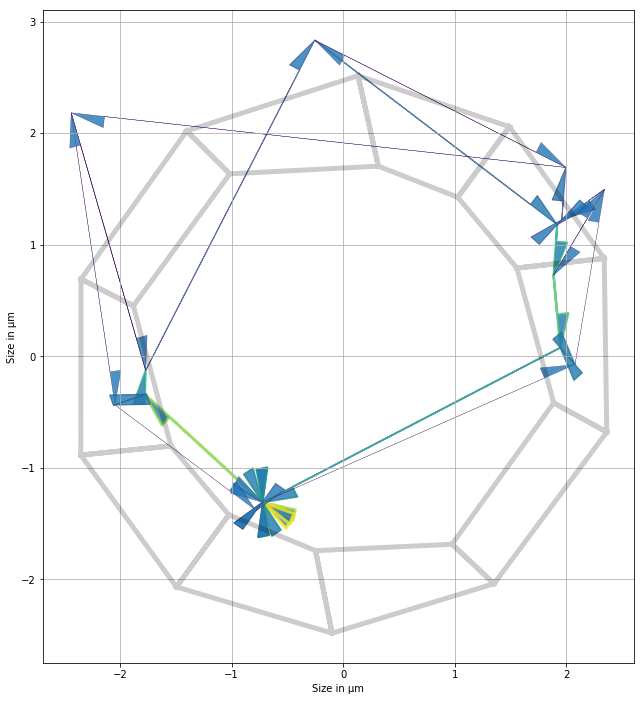

In [19]:
res_areas = adjust_tensions(organo, initial_guess['tensions'],
                            {'dic':{}, 'weight':0},
                            energy_opt, **lm_opt)
opt_areas_organo = areas_organo.copy()
opt_areas_organo.edge_df.line_tension = prepare_tensions(opt_areas_organo, res_areas.x)
Solver.find_energy_min(opt_areas_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(opt_areas_organo, organo)

In [46]:
from tyssue_taylor.adjusters.cost_functions import _distance
np.linalg.norm(_distance(organo, opt_areas_organo), axis=1)

array([0.21351275, 0.03906306, 0.34405391, 0.216591  , 0.22342525,
       0.16609912, 0.00997441, 0.31129687, 0.23616318, 0.24087041,
       0.21461559, 0.03876344, 0.22573209, 0.3637826 , 0.37767701,
       0.18513583, 0.01584088, 0.21230125, 0.37635689, 0.40818913])

In [40]:
opt_areas_organo.edge_df.line_tension

edge
0     0.016299
1     0.018162
2     0.020787
3     0.026470
4     0.023941
5     0.016149
6     0.018170
7     0.021256
8     0.025256
9     0.023838
10   -0.000711
11   -0.000526
12    0.007324
13    0.000852
14    0.000059
15   -0.000420
16   -0.000209
17    0.004945
18    0.000101
19    0.000117
20    0.009394
21    0.008527
22    0.005457
23    0.015827
24    0.002641
25    0.010253
26    0.008707
27    0.005946
28    0.014725
29    0.000860
30    0.008527
31    0.005457
32    0.015827
33    0.002641
34    0.010253
35    0.008707
36    0.005946
37    0.014725
38    0.000860
39    0.009394
Name: line_tension, dtype: float64

# Force inference with AREAS solved with basic linear algebra

[-1.22963415  1.66382592 -0.65318437  0.13389603  1.7478575   0.47909118
  0.89274563  1.39603386  1.21198085  0.66442314  0.78967513 -0.11995504
 -0.46143066 -0.38945741 -0.91793264  1.45623164 -1.63428658  0.91820917
  0.02044587 -1.7183037  -0.81216626 -1.34750129 -1.39437651 -1.46059527
 -0.94512585 -0.79544237 -0.01824622  0.81594963  0.44148876  1.37279858]
[ -0.81325002   0.60102441  -1.53096132   7.4684811    0.57212902
   2.08728534   1.12013989   0.71631501   0.82509554   1.50506498
   1.26634354  -8.33645701  -2.16717284  -2.56767484  -1.08940456
   0.68670394  -0.61188779   1.08907646  48.90962454  -0.5819693
  -1.23127498  -0.74211432  -0.71716641  -0.68465236  -1.05806015
  -1.2571621  -54.80586336   1.22556585   2.2650633    0.72843898]
Energy before optimization:  41.054158018589256
Gradient: 27.939515363822956
Solving time: 6.9339580000000005
Energy after optimization:  -266.1111723056867
Gradient: 28.707905320914048


63.33620755230207

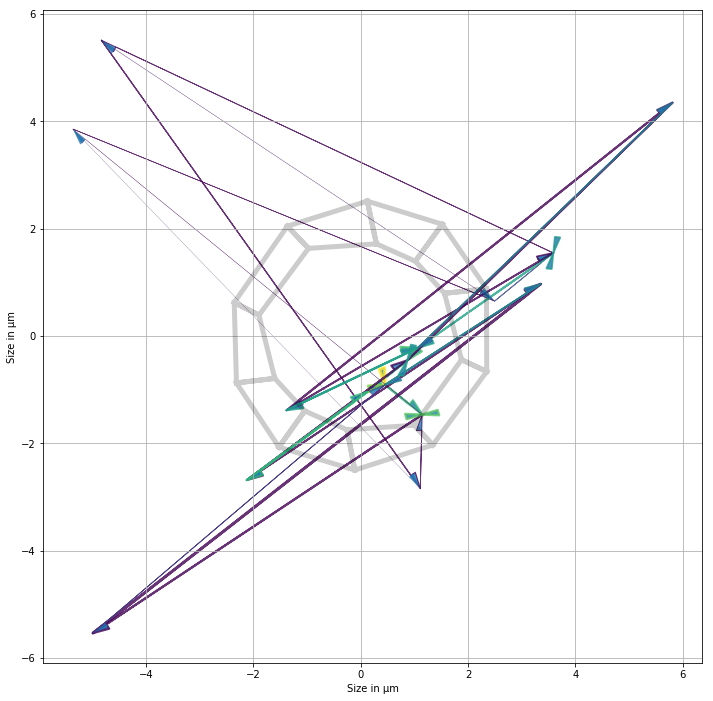

In [17]:
initial_guess = infer_forces(organo, 'LINALG', sup_param='areas')
start = time.clock()
linalg_organo = organo.copy()
linalg_organo.edge_df.line_tension = prepare_tensions(linalg_organo, initial_guess['tensions'])
linalg_organo.face_df.prefered_area = linalg_organo.face_df.area + initial_guess['areas'][:-1]
print('Energy before optimization: ', model.compute_energy(linalg_organo, False))
print('Gradient:', np.linalg.norm(model.compute_gradient(linalg_organo)))
Solver.find_energy_min(linalg_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(linalg_organo, False))
print('Gradient:', np.linalg.norm(model.compute_gradient(linalg_organo)))
print_tensions(linalg_organo, organo)
np.sum(np.linalg.norm(_distance(organo, linalg_organo), axis=1))

In [11]:
a = infer_forces(organo, 'LINALG', sup_param='areas')

[-1.22963415  1.66382592 -0.65318437  0.13389603  1.7478575   0.47909118
  0.89274563  1.39603386  1.21198085  0.66442314  0.78967513 -0.11995504
 -0.46143066 -0.38945741 -0.91793264  1.45623164 -1.63428658  0.91820917
  0.02044587 -1.7183037  -0.81216626 -1.34750129 -1.39437651 -1.46059527
 -0.94512585 -0.79544237 -0.01824622  0.81594963  0.44148876  1.37279858]
[ -0.81325002   0.60102441  -1.53096132   7.4684811    0.57212902
   2.08728534   1.12013989   0.71631501   0.82509554   1.50506498
   1.26634354  -8.33645701  -2.16717284  -2.56767484  -1.08940456
   0.68670394  -0.61188779   1.08907646  48.90962454  -0.5819693
  -1.23127498  -0.74211432  -0.71716641  -0.68465236  -1.05806015
  -1.2571621  -54.80586336   1.22556585   2.2650633    0.72843898]


In [12]:
a['tensions']

array([  9.74397837,  12.46711668,  15.22533415,   9.97641614,
        -2.56254172,  -4.75464612,   3.41828289,   8.82078015,
        10.89124644,  10.84553204, -11.61331427, -10.83559601,
       -15.18110402, -12.20489193,  -6.08659629,  -7.28628932,
        -5.63774593, -10.22188309, -11.77023817, -12.13934789,
         8.27168791,   9.96419211,   6.66621236,   2.37101909,
        11.32722176,  -1.54494032,  -0.70118124,   8.12036575,
         8.72148757,   5.70944292])

In [13]:
linalg_organo.edge_df.line_tension[:3*organo.Nf].mean()

0.9999999999999999

Comparaison des vraies tensions et des tension trouvées

R value : 0.6829221461309227 
Standard error : 6.2521449356333365


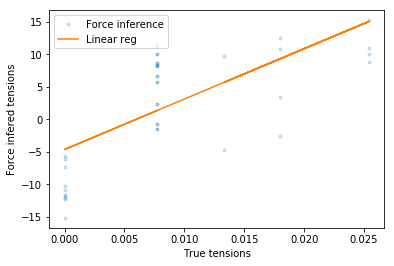

In [14]:
true_t = organo.edge_df.line_tension
opt_t = linalg_organo.edge_df.line_tension
slope, intercept, r_value, p_value, std_err = stats.linregress(true_t, opt_t)
plt.plot(true_t, opt_t, '.', alpha=0.2)
plt.plot(true_t, intercept+slope*true_t, '-')
plt.legend(('Force inference', 'Linear reg'), loc='upper left')
plt.xlabel('True tensions')
plt.ylabel('Force infered tensions')
std = np.sum(np.power(intercept+slope*true_t-opt_t, 2))
print('R value :', r_value, '\nStandard error :', (std/organo.Ne)**0.5)

Comparaison des vraies aires de préference et des aires de préference trouvées

R value : -0.3775499644081952 
Standard error : 1.2356070081794026


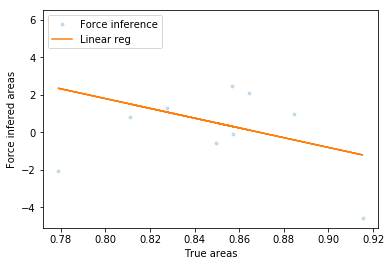

In [15]:
true_a = organo.face_df.prefered_area
opt_a = linalg_organo.face_df.prefered_area
slope, intercept, r_value, p_value, std_err = stats.linregress(true_a, opt_a)
plt.plot(true_a, opt_a, '.', alpha=0.2)
plt.plot(true_a, intercept+slope*true_a, '-')
plt.legend(('Force inference', 'Linear reg'), loc='upper left')
plt.xlabel('True areas')
plt.ylabel('Force infered areas')
std = np.sum(np.power(intercept+slope*true_a-opt_a, 2))
print('R value :', r_value, '\nStandard error :', (std/organo.Ne)**0.5)

## Minimizing distance

In [ ]:
res_linalg = adjust_tensions(linalg_organo, initial_guess['tensions'],
                             {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                             energy_opt, **lm_opt)
opt_linalg_organo = linalg_organo.copy()
opt_linalg_organo.edge_df.line_tension = prepare_tensions(opt_linalg_organo, res_linalg.x)
Solver.find_energy_min(opt_linalg_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(opt_linalg_organo, organo)

# Force inference with AREAS solved with basic linear algebra without the last constraint (norm 1)

Pas le droit car ça fait 4n+1 variables pour 4n équations...

# Force inference with AREAS solved with QP without the last constraint (norm 1)

[-1.22963415  1.66382592 -0.65318437  0.13389603  1.7478575   0.47909118
  0.89274563  1.39603386  1.21198085  0.66442314  0.78967513 -0.11995504
 -0.46143066 -0.38945741 -0.91793264  1.45623164 -1.63428658  0.91820917
  0.02044587 -1.7183037  -0.81216626 -1.34750129 -1.39437651 -1.46059527
 -0.94512585 -0.79544237 -0.01824622  0.81594963  0.44148876  1.37279858]
[ -0.81325002   0.60102441  -1.53096132   7.4684811    0.57212902
   2.08728534   1.12013989   0.71631501   0.82509554   1.50506498
   1.26634354  -8.33645701  -2.16717284  -2.56767484  -1.08940456
   0.68670394  -0.61188779   1.08907646  48.90962454  -0.5819693
  -1.23127498  -0.74211432  -0.71716641  -0.68465236  -1.05806015
  -1.2571621  -54.80586336   1.22556585   2.2650633    0.72843898]
Energy before optimization:  453.135816566936
Solving time: 8.136831
Energy after optimization:  -566.2856169806518


76.0598619845296

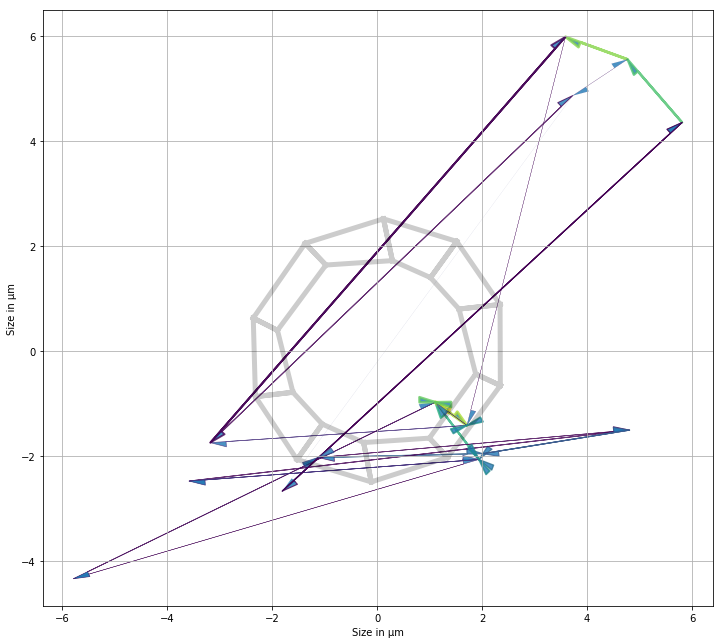

In [16]:
initial_guess = infer_forces(organo, 'MP', sup_param='areas', no_scale=True)
start = time.clock()
mp_organo = organo.copy()
mp_organo.edge_df.line_tension = prepare_tensions(mp_organo, initial_guess['tensions'])
mp_organo.face_df.prefered_area = mp_organo.face_df.area + initial_guess['areas'][:-1]
print('Energy before optimization: ', model.compute_energy(mp_organo, False))
Solver.find_energy_min(mp_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(mp_organo, False))
print_tensions(mp_organo, organo)
np.sum(np.linalg.norm(_distance(organo, mp_organo), axis=1))

Comparaison des vraies aires de préference et des aires de préference trouvées

R value : 0.050600245771717726 
Standard error : 9.368840084431781e-13


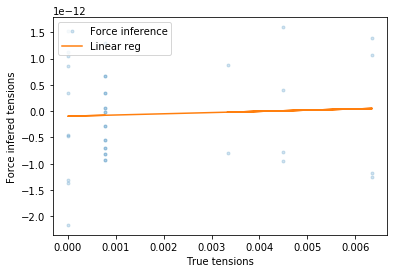

In [82]:
true_t = organo.edge_df.line_tension
opt_t = mp_organo.edge_df.line_tension
slope, intercept, r_value, p_value, std_err = stats.linregress(true_t, opt_t)
plt.plot(true_t, opt_t, '.', alpha=0.2)
plt.plot(true_t, intercept+slope*true_t, '-')
plt.legend(('Force inference', 'Linear reg'), loc='upper left')
plt.xlabel('True tensions')
plt.ylabel('Force infered tensions')
std = np.sum(np.power(intercept+slope*true_t-opt_t, 2))
print('R value :', r_value, '\nStandard error :', (std/organo.Ne)**0.5)

Comparaison des vraies aires de préference et des aires de préference trouvées

R value : 0.9999551548486445 
Standard error : 0.00019452209031272651


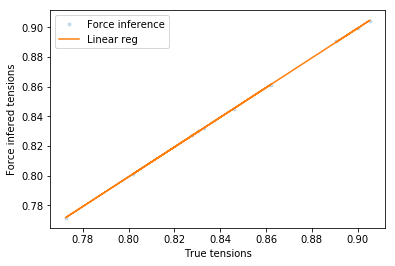

In [83]:
true_a = organo.face_df.prefered_area
opt_a = mp_organo.face_df.prefered_area
slope, intercept, r_value, p_value, std_err = stats.linregress(true_a, opt_a)
plt.plot(true_a, opt_a, '.', alpha=0.2)
plt.plot(true_a, intercept+slope*true_a, '-')
plt.legend(('Force inference', 'Linear reg'), loc='upper left')
plt.xlabel('True tensions')
plt.ylabel('Force infered tensions')
std = np.sum(np.power(intercept+slope*true_a-opt_a, 2))
print('R value :', r_value, '\nStandard error :', (std/organo.Ne)**0.5)

# Comparaison des tensions obtenues avec l'inférence prenant en compte les pressions ou les aires

Text(0,0.5,'Force infered tensions')

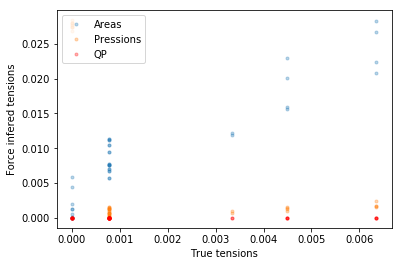

In [87]:
true_t = organo.edge_df.line_tension
area_t = areas_organo.edge_df.line_tension
mp_t = mp_organo.edge_df.line_tension
pressions_t = pressions_organo.edge_df.line_tension
plt.plot(true_t, area_t, '.',
         true_t, pressions_t, '.',
         true_t, mp_t, 'r.',
         alpha=0.3)

plt.legend(('Areas', 'Pressions', 'QP'), loc='upper left')
plt.xlabel('True tensions')
plt.ylabel('Force infered tensions')

Text(0,0.5,'Area FI')

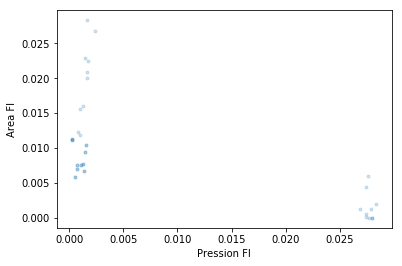

In [85]:
area_t = areas_organo.edge_df.line_tension
pressions_t = pressions_organo.edge_df.line_tension
plt.plot(pressions_t, area_t, '.',
         alpha=0.2)

plt.xlabel('Pression FI')
plt.ylabel('Area FI')

Text(0,0.5,'QP FI')

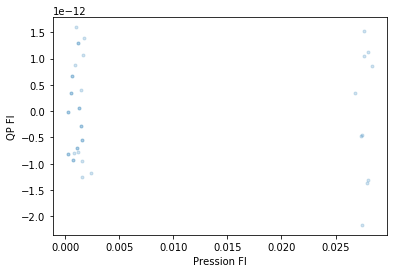

In [86]:
area_t = areas_organo.edge_df.line_tension
mp_t = mp_organo.edge_df.line_tension
plt.plot(pressions_t, mp_t, '.',
         alpha=0.2)

plt.xlabel('Pression FI')
plt.ylabel('QP FI')

In [11]:
from tyssue_taylor.adjusters.adjust_annular import adjust_areas
areas_organo = organo.copy()
print('Energy before optimization: ', model.compute_energy(areas_organo, False))
opt_areas = adjust_areas(areas_organo, organo.face_df.area.values,
                         initial_guess,
                         energy_opt, **psqp_opt)
areas_organo.face_df.prefered_area = opt_areas.x
areas_organo.edge_df.line_tension = prepare_tensions(areas_organo, initial_guess)
Solver.find_energy_min(areas_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(areas_organo, False))
print_tensions(areas_organo, organo)

Energy before optimization:  1.250873677761331


AttributeError: 'dict' object has no attribute 'x'

Solving time: 4544.368473
Energy after optimization:  0.19595661634609404


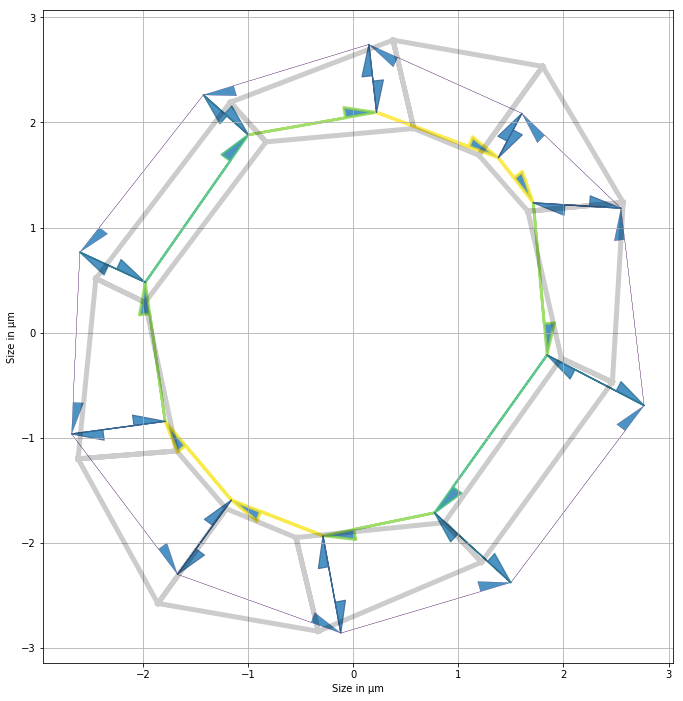

In [12]:
areas_organo.face_df.prefered_area = opt_areas['x']
areas_organo.edge_df.line_tension = prepare_tensions(areas_organo, initial_guess)
Solver.find_energy_min(areas_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(areas_organo, False))
print_tensions(areas_organo, organo)

In [32]:
organo.face_df.area.values

array([1.08988988, 1.10446245, 1.07437254, 1.035051  , 1.01169758,
       1.04075539, 1.03739242, 0.99837928, 1.04410112, 1.09257738])

5.244653773356242


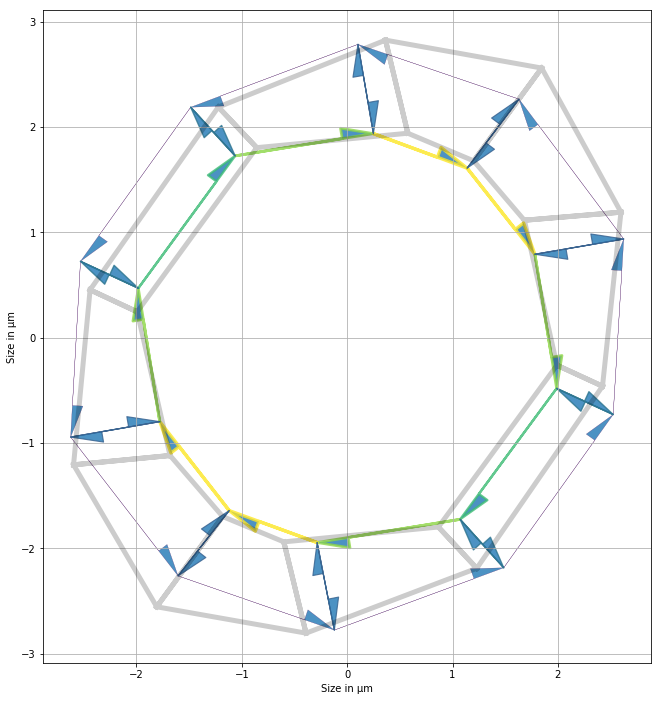

In [13]:
test_organo = organo.copy()
test_organo.edge_df.line_tension = prepare_tensions(test_organo, initial_guess)
test_organo.face_df.prefered_area = areas_opt
Solver.find_energy_min(test_organo, geom, model)
print(np.sum(np.linalg.norm(_distance(test_organo, organo), axis=1)))
print_tensions(test_organo, organo)